In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg

import scipy.stats as stats
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.science.utilities import financial_utils, time_series_utils

In [2]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [3]:
_SYMBOL = 'CB'
_DATE = '2020-05-28'

In [4]:
query = f"""
    select *
    from td.equities
    where symbol = '{_SYMBOL}'
        and market_datetime::date = '{_DATE}'::date - 1
    limit 10
    """
stocks = utils.query_db(query=query)
stocks.head(3).T

,0
symbol,CB
open,122.42
high,123.59
low,119.84
close,122.97
volume,3.80934e+06
market_datetime_epoch,1590555600000
empty,False
market_datetime,2020-05-27 05:00:00
file_datetime,2020-05-31 18:51:58


In [5]:
query = f"""
    with dates as (
        select *
            , file_datetime at time zone 'utc' as _file_datetime
            , extract('hour' from file_datetime at time zone 'utc') _hour
            , extract('month' from file_datetime) _month
            , extract('year' from file_datetime) _year
        from td.options_detail
        where symbol = '{_SYMBOL}'
        ),
    days as (
        select *
            , extract('day' from case when _hour >= 16 then _file_datetime + interval '1 day' else _file_datetime end) as _day
        from dates
        where _hour not between 9 and 16
        ),
    base as (
        select *
            , dense_rank() over (partition by symbol, _year, _month, _day order by file_datetime desc) as dr
            , (_year || '-' || lpad(_month::varchar, '2', '0') || '-' || lpad(_day::varchar, '2', '0'))::date as market_datetime
        from days
        ),
    opts as (
        select
            symbol
            , put_call
            , bid
            , ask
            , (bid + ask)/2 as price
            , total_volume
            , open_interest
            , strike
            , days_to_expiration
            , market_datetime
            , theoretical_volatility
            , interest_rate
            , n_contracts
        from base
        where dr = 1
        )
    select
        c.symbol
        , c.market_datetime
        , c.strike
        , c.days_to_expiration
        , c.bid as call_bid
        , c.ask as call_ask
        , c.price as call_price
        , p.bid as put_bid
        , p.ask as put_ask
        , p.price as put_price
        , c.price - p.price as forward
        , c.price + p.price as cumulative_premium
        , c.price + c.strike as call_breakeven
        , p.price + p.strike as put_breakeven
        , c.total_volume as call_total_volume
        , p.total_volume as put_total_volume
        , c.open_interest as call_open_interest
        , p.open_interest as put_open_interest
        , c.theoretical_volatility
        , c.interest_rate
        , c.n_contracts
    from opts as c
    inner join opts as p
        on c.symbol = p.symbol
        and c.market_datetime = p.market_datetime
        and c.put_call <> p.put_call
        and c.strike = p.strike
        and c.days_to_expiration = p.days_to_expiration
    where c.put_call = 'CALL' and c.market_datetime = '{_DATE}'
    order by c.symbol, c.market_datetime, c.strike, c.days_to_expiration
    """
options = utils.query_db(query=query)
options.head(3).T

,0,1,2
symbol,CB,CB,CB
market_datetime,2020-05-28,2020-05-28,2020-05-28
strike,50,50,50
days_to_expiration,23,86,177
call_bid,72.1,70.9,70.7
call_ask,73.8,74.4,74.8
call_price,72.95,72.65,72.75
put_bid,0,0,0.55
put_ask,0.3,0.6,1.2
put_price,0.15,0.3,0.875


### Put call parity

In [6]:
options['moneyness'] = stocks['open'].values - options['strike']
options['discount'] = options['forward'] / options['moneyness']
options['discount_rate'] = options['discount'].apply(lambda x: np.log(x) if x > 0 else -1)

options['call_distance'] = options['call_breakeven'] - stocks['open'].values
options['put_distance'] = stocks['open'].values - options['put_breakeven']
options['percent_call_distance'] = options['call_distance']/stocks['open'].values

options.head()

,symbol,market_datetime,strike,days_to_expiration,call_bid,call_ask,call_price,put_bid,put_ask,put_price,...,put_open_interest,theoretical_volatility,interest_rate,n_contracts,moneyness,discount,discount_rate,call_distance,put_distance,percent_call_distance
0,CB,2020-05-28,50.0,23.0,72.1,73.8,72.95,0.00,0.3,0.150,...,0.0,29.0,0.11,262.0,72.42,1.005247,0.005233,0.53,72.270,0.004329
1,CB,2020-05-28,50.0,86.0,70.9,74.4,72.65,0.00,0.6,0.300,...,9.0,29.0,0.11,262.0,72.42,0.999033,-0.000967,0.23,72.120,0.001879
2,CB,2020-05-28,50.0,177.0,70.7,74.8,72.75,0.55,1.2,0.875,...,0.0,29.0,0.11,262.0,72.42,0.992474,-0.007554,0.33,71.545,0.002696
3,CB,2020-05-28,50.0,233.0,70.7,75.0,72.85,0.90,1.5,1.200,...,121.0,29.0,0.11,262.0,72.42,0.989368,-0.010689,0.43,71.220,0.003512
4,CB,2020-05-28,55.0,23.0,67.1,68.8,67.95,0.00,0.4,0.200,...,0.0,29.0,0.11,262.0,67.42,1.004895,0.004883,0.53,67.220,0.004329


In [7]:
def plot(title, x, y, vline=None, ymin=None, ymax=None, hline=None, xmin=None, xmax=None, show=True):
    plt.title(title)
    plt.plot(x, y)
    if vline is not None:
        plt.vlines(
            vline,
            ymin=ymin,
            ymax=ymax,
            colors='r',
            linestyles='dotted'
        )
    if hline is not None:
        plt.hlines(
            hline,
            xmin=xmin,
            xmax=xmax,
            colors='r',
            linestyles='dotted'
        )
    if show:
        plt.show()

In [8]:
_N_EXPIRATION = 4
_expiration = np.sort(options['days_to_expiration'].unique())[_N_EXPIRATION]
_s = options[options['days_to_expiration'] == _expiration]

_N_STRIKE = 3
_strike = np.sort(options['strike'].unique())[_N_STRIKE]
_e = options[options['strike'] == _strike]

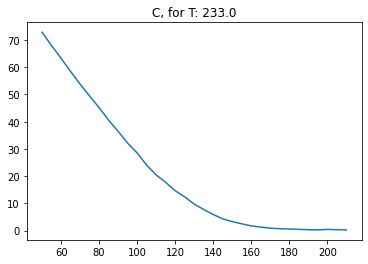

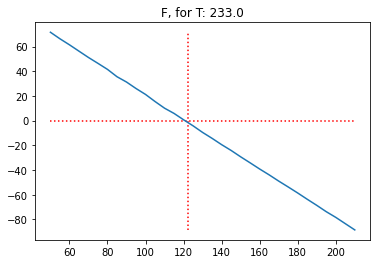

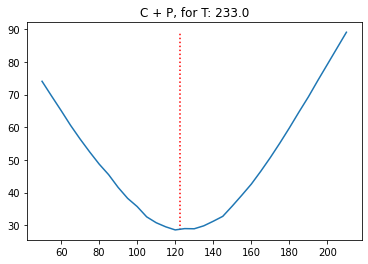

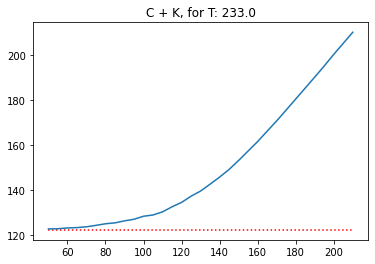

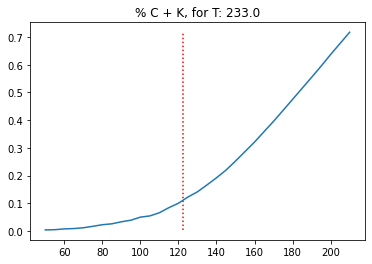

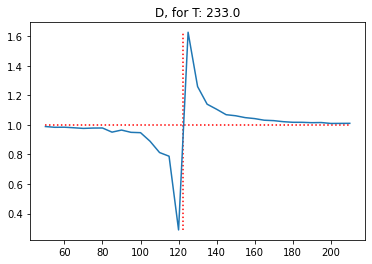

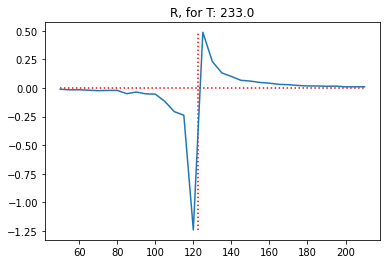

In [9]:
plot(
    title=f'C, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['call_price']
)

plot(
    title=f'F, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['forward'],
    vline=stocks['open'],
    ymin=_s['forward'].min(),
    ymax=_s['forward'].max(),
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
)

plot(
    title=f'C + P, for T: {_expiration}',
    x=_s['strike'],
    y=_s['cumulative_premium'],
    vline=stocks['open'],
    ymin=_s['cumulative_premium'].min(),
    ymax=_s['cumulative_premium'].max()
)

plot(
    title=f'C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['call_breakeven'],
    hline=stocks['open'],
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max()
)

plot(
    title=f'% C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['percent_call_distance'],
    vline=stocks['open'],
    ymin=_s['percent_call_distance'].min(),
    ymax=_s['percent_call_distance'].max()
)

plot(
    title=f'D, for T: {_expiration}',
    x=_s['strike'],
    y=_s['discount'],
    hline=1,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
    vline=stocks['open'],
    ymin=_s['discount'].min(),
    ymax=_s['discount'].max()
)

plot(
    title=f'R, for T: {_expiration}',
    x=_s['strike'],
    y=_s['discount_rate'],
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
    vline=stocks['open'],
    ymin=_s['discount_rate'].min(),
    ymax=_s['discount_rate'].max()
)

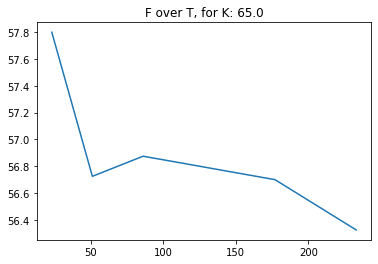

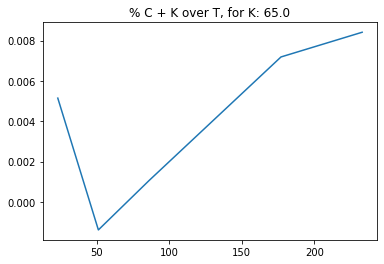

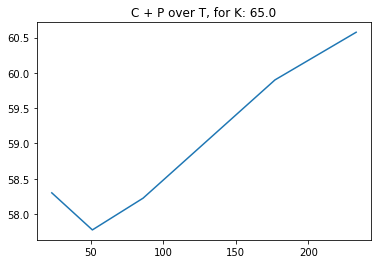

In [10]:
plot(
    title=f'F over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['forward']
)

plot(
    title=f'% C + K over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['percent_call_distance']
)

plot(
    title=f'C + P over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['cumulative_premium']
)

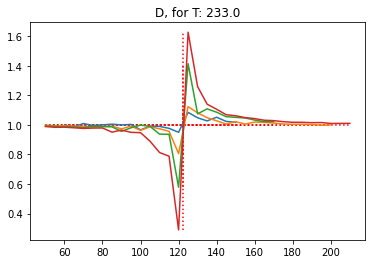

,strike,days_to_expiration,call_price,put_price,forward,discount
73,125.0,23.0,2.80,5.70,-2.90,1.124031
74,125.0,51.0,4.95,7.75,-2.80,1.085271
75,125.0,86.0,7.25,10.15,-2.90,1.124031
76,125.0,177.0,11.00,14.65,-3.65,1.414729
77,125.0,233.0,12.40,16.60,-4.20,1.627907


In [11]:
for n in [1, 2, 3, 4]:
    expiration = np.sort(options['days_to_expiration'].unique())[n]
    s = options[options['days_to_expiration'] == expiration].copy()

    plot(
        title=f'D, for T: {_expiration}',
        x=s['strike'],
        y=s['discount'],
        hline=1,
        xmin=s['strike'].min(),
        xmax=s['strike'].max(),
        vline=stocks['open'],
        ymin=s['discount'].min(),
        ymax=s['discount'].max(),
        show=False
    )

plt.show()

options.loc[options['strike']==125, ['strike', 'days_to_expiration', 'call_price', 'put_price', 'forward', 'discount']]

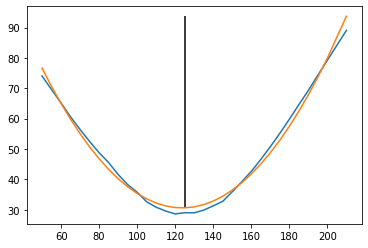

In [12]:
coefficients = np.polyfit(_s['strike'], _s['cumulative_premium'], deg=2)
smoothed_cumulative_premium = np.polyval(coefficients, _s['strike'])

plt.plot(
    _s['strike'],
    _s['cumulative_premium']
)

plt.plot(
    _s['strike'], 
    smoothed_cumulative_premium
)

plt.vlines(
    _s['strike'].values[15],
    ymin=smoothed_cumulative_premium.min(),
    ymax=smoothed_cumulative_premium.max()
)
plt.show()

In [13]:
s[['strike', 'days_to_expiration', 'call_price', 'put_price', 'forward', 'discount', 'interest_rate', 'theoretical_volatility']]

,strike,days_to_expiration,call_price,put_price,forward,discount,interest_rate,theoretical_volatility
3,50.0,233.0,72.850,1.200,71.650,0.989368,0.11,29.0
7,55.0,233.0,67.950,1.600,66.350,0.984129,0.11,29.0
12,60.0,233.0,63.300,1.825,61.475,0.984861,0.11,29.0
17,65.0,233.0,58.450,2.125,56.325,0.980930,0.11,29.0
22,70.0,233.0,53.800,2.600,51.200,0.976726,0.11,29.0
27,75.0,233.0,49.450,3.025,46.425,0.979017,0.11,29.0
32,80.0,233.0,45.150,3.600,41.550,0.979491,0.11,29.0
37,85.0,233.0,40.550,4.950,35.600,0.951363,0.11,29.0
42,90.0,233.0,36.450,5.150,31.300,0.965453,0.11,29.0
47,95.0,233.0,32.150,6.100,26.050,0.950036,0.11,29.0


In [14]:
stocks['open'].values[0]

122.42

In [15]:
CURRENT_OPTION_PRICE = 4.3
STRIKE = 145
RISK_FREE_RATE = .001
DAYS_TO_MATURITY = 233
VOLATILITY = .2934

bs = financial_utils.BlackScholes(
    current_option_price=CURRENT_OPTION_PRICE,
    stock_price=stocks['open'].values[0],
    strike=STRIKE,
    risk_free_rate=RISK_FREE_RATE,
    days_to_maturity=DAYS_TO_MATURITY,
    volatility=VOLATILITY,
)

In [16]:
bs.option_price

4.299500837354017

In [17]:
bs.implied_volatility

0.29341533500891576

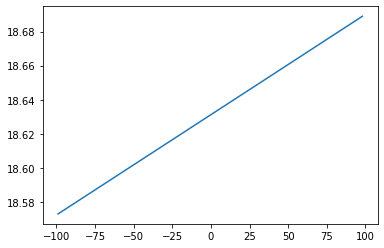

In [29]:
plt.plot(bs.get_greek(greek='ro', steps=99))
plt.show()

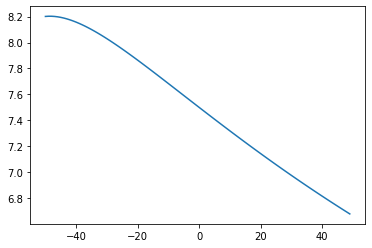

In [25]:
plt.plot(bs.get_greek(greek='theta', steps=50))
plt.show()

In [21]:
bs.time

0.6383561643835617

In [22]:
bs.get_greek(greek='theta')

-30    8.029642
-29    8.014309
-28    7.998645
-27    7.982676
-26    7.966429
         ...   
 26    7.042721
 27    7.026054
 28    7.009466
 29    6.992956
 30         NaN
Name: theta, Length: 61, dtype: float64